Gustavo
Agente de Estado Interno

Agente Inspirado en el Simulated Annealing
Agente Metaheurístico

Completed: 12 steps
Run time: 0:00:00.039520
Simulation finished


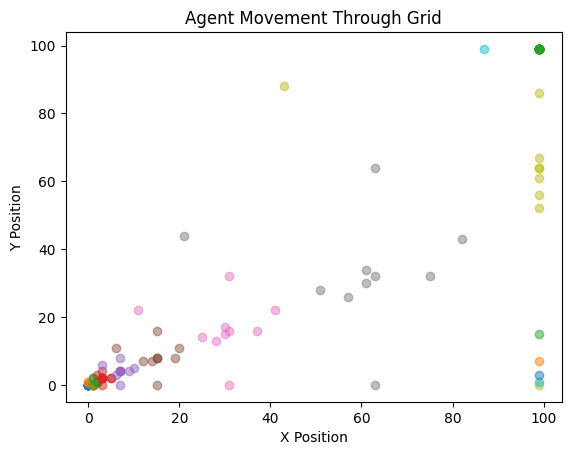

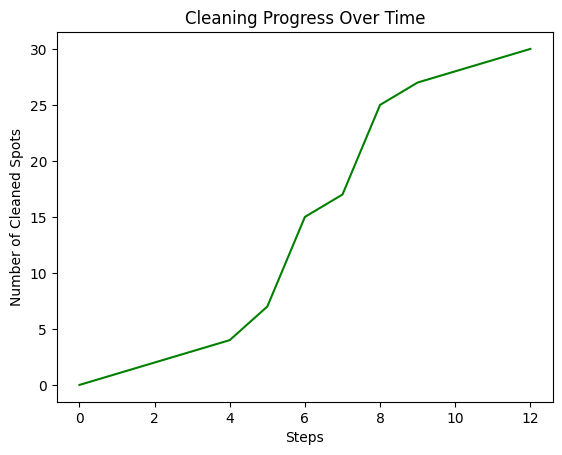

In [19]:
# Model design
import agentpy as ap
import numpy as np
import math

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


class cleaningAgent(ap.Agent):
  def setup(self):
    self.cleaned = 0
    self.temp = 10 # Start with high randomness

  def move(self):
    currPos = self.model.grid.positions[self]
    currScore = self.cleaned
    bestMove = None
    bestScore = -math.inf

    vec = [(1,0),(0,1),(-1,0),(0,-1)]
    posMoves = []
    for i in vec:
      p = (currPos[0] + i[0], currPos[1] + i[1])
      if 0 <= p[0] < self.model.grid.shape[0] and 0 <= p[1] < self.model.grid.shape[1]:
        posMoves.append(p)


    for i in posMoves:
      currScore = int(self.model.grid.clean[i]) # 1 si esta sucio 0 si limpio
      if currScore > bestScore:
        bestMove = i
        bestScore = currScore

    if np.random.rand() < self.model.p.alpha / 100:
      self.model.grid.move_by(self, posMoves[np.random.choice(len(posMoves))])
    else:
      self.model.grid.move_by(self, bestMove)

    self.temp *= 0.99


  def clean(self):
    x, y = self.model.grid.positions[self]
    if self.model.grid.clean[x, y]:  # If cell is dirty
      self.model.grid.clean[x, y] = False  # Mark as cleaned
      self.cleaned += 1



class CleaningModel(ap.Model):
  def setup(self):
    self.grid = ap.Grid(self, (self.p.x, self.p.y)) # Create the grid
    self.agents = ap.AgentList(self, self.p.agents, cleaningAgent) # Create the agents
    self.grid.add_agents(self.agents, positions=[(0, 0)] * self.p.agents) # Add agents to grid at 0,0
    
    # Dirty random spaces in grid
    # 3 hrs me tomo hacer esto *-*
    self.grid.add_field('clean', values=np.full(self.grid.shape, True))  # Default all clean
    stain_positions = np.random.choice(self.grid.shape[0] * self.grid.shape[1], self.p.stains, replace=False) # Creates a numpy ndarray with dirty spaces
    for pos in np.unravel_index(stain_positions, self.grid.shape):
      self.grid.clean[pos] = False # Sets the grid in that spot as dirty

      self.agent_positions = []  # Store agent positions for visualization
      self.cleaning_history = []


  def step(self):
    self.agents.move()
    self.agents.clean()


  def update(self):
    positions = [self.grid.positions[agent] for agent in self.agents]
    self.agent_positions.append(positions)
    
    cleaned = sum(agent.cleaned for agent in self.agents)
    self.cleaning_history.append(cleaned)
            
    cleaned_count = sum(agent.cleaned for agent in self.agents)  # Total cleaned by all agents
    self.record("cleaned_spots", cleaned_count)

    if cleaned_count == self.p.stains:
      self.stop()

  def end(self):
    self.agents.record(["cleaned"])


parameters = {
  'x': 100,       # Grid size in x axis
  'y': 100,       # Gird size in y axis
  'agents': 10,   # Agent Amount
  'alpha': 30,    # Probability for random outcome 0 - 100 %
  'stains': 30,   # Spots to clean
  'steps': 100,
}


model = CleaningModel(parameters)
results = model.run()

results

#                                         #
# Funciones de Graficado hecho con Chatgpt#
#                                         #

# After the model has run
agent_positions = model.agent_positions  # This is a list of agent positions for each step
cleaning_history = model.cleaning_history  # This tracks the total number of cleaned spots over time

# Plot the agent movement
for step, positions in enumerate(agent_positions):
  x_pos = [pos[0] for pos in positions]  # x-coordinates of agents
  y_pos = [pos[1] for pos in positions]  # y-coordinates of agents
  plt.scatter(x_pos, y_pos, label=f'Step {step}', alpha=0.5)  # Scatter plot for agent positions

plt.title('Agent Movement Through Grid')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

# Plot the cleaning history
plt.plot(range(len(cleaning_history)), cleaning_history, label="Cleaning History", color='green')
plt.title('Cleaning Progress Over Time')
plt.xlabel('Steps')
plt.ylabel('Number of Cleaned Spots')
plt.show()
